***

## Data 620 Final Project
Fall 2019

### Authors
* Scott Karr
* Vikas Sinha

***

# <h1><center>Topic Modeling with Gensim (Python)</center></h1>
![brain](brain.png)! 

### <h1><center>Corpus:  *Behavioral Economics & Machine Learning*</center></h1>

# Problem Statement

**Background** The purpose of building a Topic Model is to uncover the hidden structure of a collection of texts.  The Latent Dirichlet Allocation (LDA) algorithm used in this project has excellent implementations using the Python Gensim package. The challenge however, is to extract topics of good quality that are clear, segregated and meaningful. Doing so depends heavily on the strategy for text preprocessing that best yields intuition about these topics.  A successful model can be determined by one that can address the interogration of the following items by
*(1) Topic prevalence, (2) Topic similarity and (3) Topic interpretation.*
    
This exercise attempts to develop a meaningful topic model by comparing contents of a corpus at two different time periods and in two different subject areas.  What is of interest to the authors is whether these distinctions show up in a meaningful way in the topics that LDA model generates. To build a meaningful model, documents were reviewed by subject and whether they contributed to meaningful variation in our corpus.  This documents were reviewed for inclusion in an interative trial-and-error manner to get to an interpretable result.
    
**Objective** This project uses the LDA topic modeling algorhithm to determine trends and relationships in two academic disciplines: Machine Learning and Behavioral Economics.  There were two particular interests being investigated:
    1. When comparing the same subject at different snapshots in time, is there a variation in the topics generated and have they changed signficantly? 
    2. When comparing two separate subjects, does the expected variation in topics generated discernible?
    
**Our Corpus** The dataset consists of selected papers in these categories primarily drawn from the Arxiv.org academic repository of Cornell University.
For the purposes of time comparisons, a corpus has been built consisting of papers from 2 date ranges 2012 and 2018.  

**Process**

	.	Loading data
	.	Data cleaning
	.	Exploratory analysis
	.	Preparing data for LDA analysis
	.	Analyzing LDA model result
    .	Conclusions

**Dimensional Reduction** Rather than representing text T as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, it can be represented in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}

**Unsupervised Learning** Like clustering, the number of topics or clusters is an output parameter. Topic modeling builds clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight

**Tagging** Abstract “topics” that occur in a collection of documents that best represents the information in them.
There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)


### Sources: 
[1] Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_mode     
[2] Topic Modeling with Gensim (Python) https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python      
[3] Topic Modeling in Python: Latent Dirichlet Allocation (LDA) https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# Prerequisites – Download packages

*We use stopwords from NLTK and Spacy’s en model for text pre-processing and for lemmatization.*

(Lemmatization converts a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.)

### Import Packages
*The core packages used in this tutorial are re, gensim, spacy and pyLDAvis. Besides this we will also using matplotlib, numpy and pandas for data handling and visualization. Let’s import them.*

In [6]:
import sys
import nltk
import datetime
import glob
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Prepare Stopwords
*We have already downloaded the stopwords. Let’s import them and make it available in stop_words.*

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Import & Converting to PDF  using Pdfminer

In [9]:
import pdfminer
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,
                                  caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

def show_datetime(str1):
    now = datetime.datetime.now()
    print (str1)
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return

# Loading data

In [15]:

ml2018_files = [
    "data/ml/2018/1801.04540.1801_04540.pdf",
    #"data/ml/2018/1801.05039.1801_05039.pdf",
    #"data/ml/2018/1801.00905.1801_00905.pdf",
    "data/ml/2018/1801.03558.1801_03558.pdf",
    "data/ml/2018/1801.03226.1801_03226.pdf",
    "data/ml/2018/1801.00282.1801_00282.pdf",
    "data/ml/2018/1801.02780.1801_02780.pdf",
    "data/ml/2018/1801.00903.1801_00903.pdf",
    "data/ml/2018/1801.09403.1801_09403.pdf",
    "data/ml/2018/1801.02567.1801_02567.pdf",
    "data/ml/2018/1801.09856.1801_09856.pdf",
    "data/ml/2018/1801.01204.1801_01204.pdf",
    "data/ml/2018/1801.02901.1801_02901.pdf",
    "data/ml/2018/1801.01596.1801_01596.pdf",
    "data/ml/2018/1801.00823.1801_00823.pdf"
    ]

econ2018_files = [
    "data/econ/2018/1801.00369.1801_00369.pdf",
    "data/econ/2018/1801.01948.1801_01948.pdf",
    "data/econ/2018/1801.02958.1801_02958.pdf",
    #"data/econ/2018/advanced-economicsciencesprize2018.pdf",
    "data/econ/2018/1801.04714.1801_04714.pdf"
    ]


show_datetime("Converting Econ files from 2018")
econ2018 = []
for fn1 in econ2018_files:
    print(fn1)
    t = convert_pdf_to_txt(fn1)
    econ2018.append(t)


# Load Machine Learning Papers
#    
show_datetime("\nConverting ML files from 2018")
ml2018 = []
for fn2 in ml2018_files:
    print(fn2)
    t = convert_pdf_to_txt(fn2)
    ml2018.append(t)


show_datetime("done")

Converting Econ files from 2018
2019-12-21 12:54:35
data/econ/2018/1801.00369.1801_00369.pdf
data/econ/2018/1801.01948.1801_01948.pdf
data/econ/2018/1801.02958.1801_02958.pdf
data/econ/2018/1801.04714.1801_04714.pdf

Converting ML files from 2018
2019-12-21 12:54:57
data/ml/2018/1801.04540.1801_04540.pdf
data/ml/2018/1801.03558.1801_03558.pdf
data/ml/2018/1801.03226.1801_03226.pdf
data/ml/2018/1801.00282.1801_00282.pdf
data/ml/2018/1801.02780.1801_02780.pdf
data/ml/2018/1801.00903.1801_00903.pdf
data/ml/2018/1801.09403.1801_09403.pdf
data/ml/2018/1801.02567.1801_02567.pdf
data/ml/2018/1801.09856.1801_09856.pdf
data/ml/2018/1801.01204.1801_01204.pdf
data/ml/2018/1801.02901.1801_02901.pdf
data/ml/2018/1801.01596.1801_01596.pdf
data/ml/2018/1801.00823.1801_00823.pdf
done
2019-12-21 12:55:30


In [16]:
len(econ2018)

4

In [17]:
len(ml2018)

13

# Data Cleaning
Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

Remove punctuation/lower casing
Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [18]:
corpus = econ2018 + ml2018
corpus = [re.sub('\S*@\S*\s?', '', sent) for sent in corpus]
corpus = [re.sub('\s+', ' ', sent) for sent in corpus]
pprint(corpus[:1])

[' ABSTRACT Resource Abundance and Life Expectancy Bahram Sanginabadi December '
 '2017 Economics Department University of Hawaii at Manoa This paper '
 'investigates the impacts of major natural resource discoveries since 1960 on '
 'life expectancy in the nations that they were resource poor prior to the '
 'discoveries. Previous literature explains the relation between nations '
 'wealth and life expectancy, but it has been silent about the impacts of '
 'resource discoveries on life expectancy. We attempt to fill this gap in this '
 'study. An important advantage of this study is that as the previous '
 'researchers argued resource discovery could be an exogenous variable. We use '
 'longitudinal data from 1960 to 2014 and we apply three modern empirical '
 'methods including Difference-in-Differences, Event studies, and Synthetic '
 'Control approach, to investigate the main question of the research which is '
 '“how resource discoveries affect life expectancy?”. The findings show

In [19]:
corpus = ml2018
corpus = [re.sub('\S*@\S*\s?', '', sent) for sent in corpus]
corpus = [re.sub('\s+', ' ', sent) for sent in corpus]
pprint(corpus[:1])

['8 1 0 2 r a M 0 2 ] G L . s c [ 2 v 0 4 5 4 0 . 1 0 8 1 : v i X r a '
 'Published as a conference paper at ICLR 2018 FIX YOUR CLASSIFIER: THE '
 'MARGINAL VALUE OF TRAINING THE LAST WEIGHT LAYER Elad Hoffer, Itay Hubara, '
 'Daniel Soudry Department of Electrical Engineering Technion Haifa, 320003, '
 'Israel elad.hoffer, itay.hubara, ABSTRACT Neural networks are commonly used '
 'as models for classiﬁcation for a wide variety of tasks. Typically, a '
 'learned afﬁne transformation is placed at the end of such models, yielding a '
 'per-class value used for classiﬁcation. This classiﬁer can have a vast '
 'number of parameters, which grows linearly with the number of possible '
 'classes, thus requiring increasingly more resources. In this work we argue '
 'that this classiﬁer can be ﬁxed, up to a global scale con- stant, with '
 'little or no loss of accuracy for most tasks, allowing memory and com- '
 'putational beneﬁts. Moreover, we show that by initializing the classiﬁer '
 'wit

### Remove special characters

Remove newlines and extra spaces using regular expressions.

In [20]:
# Assign list of docs to 'data'
data = econ2018 + ml2018

# Remove Email signifiers if any
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

[' ABSTRACT Resource Abundance and Life Expectancy Bahram Sanginabadi December '
 '2017 Economics Department University of Hawaii at Manoa This paper '
 'investigates the impacts of major natural resource discoveries since 1960 on '
 'life expectancy in the nations that they were resource poor prior to the '
 'discoveries. Previous literature explains the relation between nations '
 'wealth and life expectancy, but it has been silent about the impacts of '
 'resource discoveries on life expectancy. We attempt to fill this gap in this '
 'study. An important advantage of this study is that as the previous '
 'researchers argued resource discovery could be an exogenous variable. We use '
 'longitudinal data from 1960 to 2014 and we apply three modern empirical '
 'methods including Difference-in-Differences, Event studies, and Synthetic '
 'Control approach, to investigate the main question of the research which is '
 '“how resource discoveries affect life expectancy?”. The findings show

In [21]:
len(data)
#data_words[0]

17

*After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.*

*Gensim’s simple_preprocess is great for this.*

### Tokenize words and Clean-up text

*Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.*

*Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.*

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['abstract', 'resource', 'abundance', 'and', 'life', 'expectancy', 'bahram', 'sanginabadi', 'december', 'economics', 'department', 'university', 'of', 'hawaii', 'at', 'manoa', 'this', 'paper', 'investigates', 'the', 'impacts', 'of', 'major', 'natural', 'resource', 'discoveries', 'since', 'on', 'life', 'expectancy', 'in', 'the', 'nations', 'that', 'they', 'were', 'resource', 'poor', 'prior', 'to', 'the', 'discoveries', 'previous', 'literature', 'explains', 'the', 'relation', 'between', 'nations', 'wealth', 'and', 'life', 'expectancy', 'but', 'it', 'has', 'been', 'silent', 'about', 'the', 'impacts', 'of', 'resource', 'discoveries', 'on', 'life', 'expectancy', 'we', 'attempt', 'to', 'fill', 'this', 'gap', 'in', 'this', 'study', 'an', 'important', 'advantage', 'of', 'this', 'study', 'is', 'that', 'as', 'the', 'previous', 'researchers', 'argued', 'resource', 'discovery', 'could', 'be', 'an', 'exogenous', 'variable', 'we', 'use', 'longitudinal', 'data', 'from', 'to', 'and', 'we', 'apply', '

### Creating Bigram and Trigram Models

*Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.*

*Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.*

*Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.*

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['abstract', 'resource_abundance', 'and', 'life_expectancy', 'bahram', 'sanginabadi', 'december', 'economics', 'department', 'university', 'of', 'hawaii', 'at', 'manoa', 'this', 'paper', 'investigates', 'the', 'impacts', 'of', 'major_natural', 'resource_discoveries', 'since', 'on', 'life_expectancy', 'in', 'the', 'nations', 'that', 'they', 'were', 'resource_poor', 'prior', 'to', 'the', 'discoveries', 'previous', 'literature', 'explains', 'the', 'relation_between', 'nations', 'wealth', 'and', 'life_expectancy', 'but', 'it', 'has_been', 'silent', 'about', 'the', 'impacts', 'of', 'resource_discoveries', 'on', 'life_expectancy', 'we', 'attempt', 'to', 'fill', 'this', 'gap', 'in', 'this', 'study', 'an', 'important', 'advantage', 'of', 'this', 'study', 'is', 'that', 'as', 'the', 'previous', 'researchers', 'argued', 'resource_discovery', 'could', 'be', 'an', 'exogenous', 'variable', 'we', 'use', 'longitudinal', 'data', 'from', 'to', 'and', 'we', 'apply', 'three', 'modern', 'empirical', 'metho

### Remove Stopwords, Make Bigrams and Lemmatize

*The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.*

In [24]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

*Let’s call the functions in order.*

In [25]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['sanginabadi', 'paper', 'investigate', 'impact', 'resource_discoverie', 'life_expectancy', 'nation', 'prior', 'discovery', 'previous', 'literature', 'explain', 'relation', 'nation', 'wealth', 'life_expectancy', 'silent', 'impact', 'life_expectancy', 'attempt', 'fill', 'gap', 'study', 'important', 'advantage', 'study', 'previous', 'researcher', 'argue', 'could', 'exogenous', 'variable', 'longitudinal', 'datum', 'apply', 'modern', 'empirical', 'method', 'include', 'difference', 'difference', 'event', 'study', 'synthetic_control', 'approach', 'investigate', 'research', 'affect', 'life_expectancy', 'finding', 'show', 'oman', 'positive', 'significant', 'impact', 'life_expectancy', 'effect', 'european_countrie', 'mostly', 'negative', 'key', 'word', 'discovery', 'jel', 'classification', 'introduction', 'irony', 'world', 'country', 'bless', 'easy', 'income', 'necessarily', 'bless', 'high', 'welfare', 'nation', 'income', 'whatsoever', 'fact', 'abundant', 'nation', 'extremely', 'diverse', 'pol

# Exploratory analysis

### Wordcloud results

In [26]:
from pandas.core.common import flatten

l0 = list(flatten(data_lemmatized[0])) 
l1 = list(flatten(data_lemmatized[1])) 
l2 = list(flatten(data_lemmatized[2])) 
l3 = list(flatten(data_lemmatized[3])) 
l4 = list(flatten(data_lemmatized[4])) 
l5 = list(flatten(data_lemmatized[5])) 
l6 = list(flatten(data_lemmatized[6])) 
l7 = list(flatten(data_lemmatized[7])) 
l8 = list(flatten(data_lemmatized[8])) 
l9 = list(flatten(data_lemmatized[9])) 

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(2, figsize=(20,3))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=12)
        #fig.subplots_adjust(l=2)
    plt.imshow(wordcloud)
    plt.show()

### Displaying Wordclouds

We generate wordclouds for a selection of Economics and Machine Learning papers

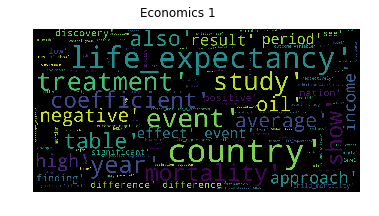

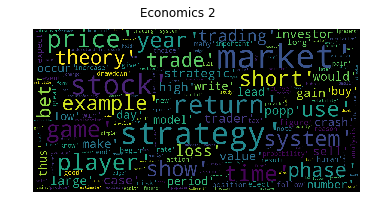

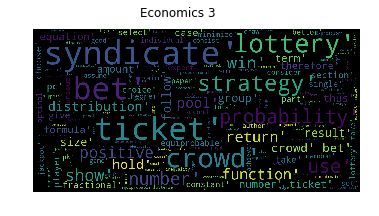

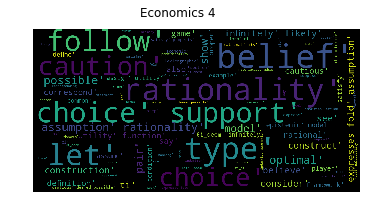

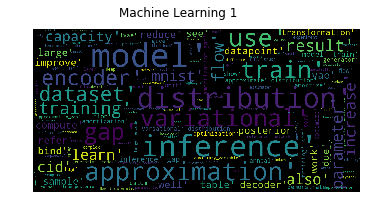

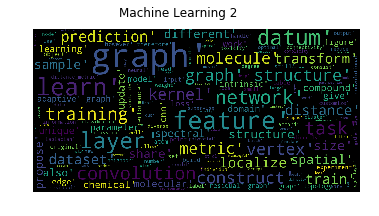

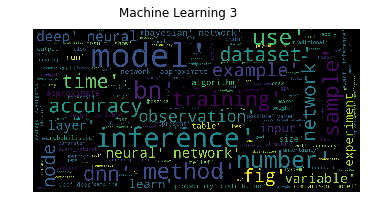

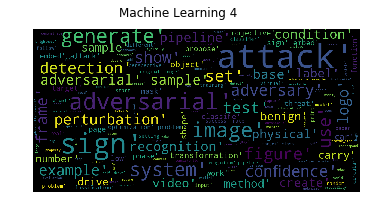

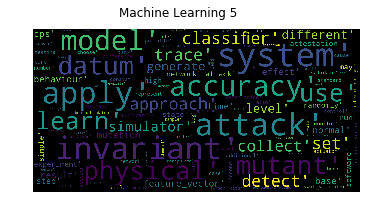

In [30]:
show_wordcloud(l0, 'Economics 1')
show_wordcloud(l1, 'Economics 2')
show_wordcloud(l2, 'Economics 3')
show_wordcloud(l3, 'Economics 4')
#show_wordcloud(l4, 'Economics 5')

show_wordcloud(l5, 'Machine Learning 1')
show_wordcloud(l6, 'Machine Learning 2')
show_wordcloud(l7, 'Machine Learning 3')
show_wordcloud(l8, 'Machine Learning 4')
show_wordcloud(l9, 'Machine Learning 5')

# Preparing data for LDA analysis
*Transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.*

*We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.*

### Create the Dictionary and Corpus needed for Topic Modeling

*The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.*

In [40]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print((corpus[:1][0])[0:64])

[(0, 2), (1, 2), (2, 1), (3, 3), (4, 1), (5, 4), (6, 2), (7, 1), (8, 1), (9, 1), (10, 12), (11, 1), (12, 1), (13, 14), (14, 1), (15, 2), (16, 1), (17, 4), (18, 2), (19, 14), (20, 3), (21, 19), (22, 1), (23, 1), (24, 2), (25, 1), (26, 30), (27, 2), (28, 2), (29, 2), (30, 1), (31, 4), (32, 1), (33, 11), (34, 23), (35, 2), (36, 1), (37, 6), (38, 7), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 4), (45, 2), (46, 8), (47, 3), (48, 1), (49, 2), (50, 1), (51, 30), (52, 1), (53, 1), (54, 8), (55, 3), (56, 1), (57, 5), (58, 1), (59, 1), (60, 1), (61, 1), (62, 12), (63, 31)]


In [48]:
type(id2word)

gensim.corpora.dictionary.Dictionary

## Term-frequency Listing of Corpus
Gensim generates (word, frequency) pairs for each word in the corpus. This is used as input by the LDA model.

In [49]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('absolute', 2),
  ('abundance', 2),
  ('abundancy', 1),
  ('abundant', 3),
  ('access', 1),
  ('accord', 4),
  ('account', 2),
  ('acknowledgment', 1),
  ('act', 1),
  ('add', 1),
  ('addition', 12),
  ('address', 1),
  ('adjust', 1),
  ('adult', 14),
  ('adult_male', 1),
  ('adult_mortality', 2),
  ('advanced', 1),
  ('advantage', 4),
  ('adverse', 2),
  ('affect', 14),
  ('african', 3),
  ('age', 19),
  ('allocation', 1),
  ('allow', 1),
  ('almost', 2),
  ('already', 1),
  ('also', 30),
  ('alter', 2),
  ('alternative', 2),
  ('always', 2),
  ('animal', 1),
  ('answer', 4),
  ('anywhere', 1),
  ('apply', 11),
  ('approach', 23),
  ('arbitrary', 2),
  ('area', 1),
  ('argue', 6),
  ('around_year', 7),
  ('asian', 1),
  ('assert', 1),
  ('asset', 1),
  ('assign', 1),
  ('assignment', 2),
  ('associate', 4),
  ('association', 2),
  ('assumption', 8),
  ('attempt', 3),
  ('attenuate', 1),
  ('author', 2),
  ('automobile', 1),
  ('average', 30),
  ('avoid', 1),
  ('axis', 1),
  ('barr

### Building the Topic Model

*We now train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.*

*Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.*

*chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.*

In [50]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

*The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.*

*You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.*

In [51]:
# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"model" + 0.020*"inference" + 0.020*"distribution" + 0.012*"train" + '
  '0.012*"gap" + 0.012*"approximation" + 0.012*"variational" + 0.011*"encoder" '
  '+ 0.010*"training" + 0.009*"use"'),
 (1,
  '0.015*"patient" + 0.015*"cluster" + 0.013*"feature" + 0.013*"sample" + '
  '0.009*"problem" + 0.009*"set" + 0.009*"use" + 0.007*"value" + '
  '0.006*"classiﬁer" + 0.006*"method"'),
 (2,
  '0.001*"model" + 0.001*"set" + 0.001*"use" + 0.001*"result" + '
  '0.001*"problem" + 0.001*"learn" + 0.001*"sample" + 0.001*"feature" + '
  '0.000*"training" + 0.000*"case"'),
 (3,
  '0.025*"life_expectancy" + 0.024*"event" + 0.022*"country" + 0.015*"study" + '
  '0.015*"year" + 0.014*"difference" + 0.013*"significant" + 0.013*"effect" + '
  '0.013*"show" + 0.012*"mortality"'),
 (4,
  '0.017*"attack" + 0.014*"system" + 0.012*"apply" + 0.012*"invariant" + '
  '0.012*"trace" + 0.012*"datum" + 0.011*"model" + 0.010*"mutant" + '
  '0.010*"accuracy" + 0.008*"set"'),
 (5,
  '0.021*"noise" + 0.015*"

*How to interpret this?*

*Topic 0 is a represented as 0.001*"model" + 0.001*"use" + 0.001*"set" + 0.000*"datum" + 0.000*"result" '
  '+ 0.000*"number" + 0.000*"function" + 0.000*"show" + 0.000*"probability" + '
  '0.000*"learn"
  
*It means the top 10 keywords that contribute to this topic are: ‘model’, ‘use’, ‘set’.. and so on and the weight of ‘model’ on topic .001.

*The weights reflect how important a keyword is to that topic.*

*Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.*

*Likewise, can you go through the remaining topic keywords and judge what the topic is?*

### Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [53]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.208971184533758

Coherence Score:  0.48760304943788124


*We obtained a coherence score of 0.48.*

# Analyzing LDA model result

### Visualize the topics
*Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.*

### Analyzing LDA model results
Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

	.	Better understanding and interpreting individual topics, and
	.	Better understanding the relationships between the topics.

**For (1)**  *you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.*

**For (2)** *exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.*

### **PyLDAviz visualization** feature presents three important features: 

**First** the circles on the left side represent numbered topics that were extracted from the corpus and the size of each circle represents that topic’s prevalence within the corpus.  Topics are sorted in order of a topic circle's prevalence or size.

**Second** the distance between two topic circles represents the topic’s relative similarity in a 2-dimensional representation although these distances in are representing multi-dimensional distances in the TOPIC X WORD matrix.  

**Third** on the right side are the top 30 most relevant words per topic.  The red bar represents the terms appearance in the current topic versus the blue bar which represents the term frequency thorough all topics.  Note that the value of lama in the LDA model strikes a balance between emphasizing “jargon” particular to the currently selected topic versus “laymen” oriented terms which are shared between topics.  Adjusting lambda will reorder the list of relevant terms adjusted for the current balance between these two options.  Increasing lambda will make the topic more readable to a layman.  Also, hovering over a particular word in the term list will display the topic circles for which that term is most prevalent.

In [54]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.067108 -0.085995       1        1  19.385563
1      0.099965 -0.027595       2        1  15.017830
13     0.109121  0.051299       3        1  12.959830
10     0.138149  0.001587       4        1  10.034262
5      0.059729 -0.056981       5        1   9.441312
4      0.074068 -0.017077       6        1   8.539011
3     -0.046397 -0.274402       7        1   6.893764
0      0.099075  0.046216       8        1   5.823353
7      0.066404  0.031793       9        1   4.436095
8      0.085652  0.071086      10        1   4.370842
6     -0.009549  0.070082      11        1   3.095545
9     -0.130105  0.045684      12        1   0.000683
2     -0.155746  0.046807      13        1   0.000650
12    -0.163453  0.051484      14        1   0.000628
11    -0.159804  0.046014      15        1   0.000628, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
308   Default  198.000000            graph  198.000000  30.0000  30.0000
444   Default  403.000000            model  403.000000  29.0000  29.0000
838   Default  122.000000           attack  122.000000  28.0000  28.0000
245   Default   98.000000            event   98.000000  27.0000  27.0000
4134  Default  109.000000            noise  109.000000  26.0000  26.0000
2656  Default  122.000000        inference  122.000000  25.0000  25.0000
399   Default   84.000000  life_expectancy   84.000000  24.0000  24.0000
4791  Default  113.000000          patient  113.000000  23.0000  23.0000
1092  Default  144.000000     distribution  144.000000  22.0000  22.0000
717   Default  410.000000              use  410.000000  21.0000  21.0000
2673  Default  173.000000            layer  173.000000  20.0000  20.0000
2556  Default  118.000000          cluster  118.000000  19.0000  19.0000
136   Default   76.000000          country   76.000000  18.0000  18.0000
1474  Default  225.000000          network  225.000000  17.0000  17.0000
874   Default  112.000000              bet  112.000000  16.0000  16.0000
2555  Default  115.000000        classiﬁer  115.000000  15.0000  15.0000
1423  Default   97.000000           market   97.000000  14.0000  14.0000
2808  Default  215.000000         training  215.000000  13.0000  13.0000
1615  Default  154.000000      probability  154.000000  12.0000  12.0000
1206  Default  223.000000          feature  223.000000  11.0000  11.0000
1372  Default  235.000000            learn  235.000000  10.0000  10.0000
613   Default  293.000000              set  293.000000   9.0000   9.0000
2347  Default   83.000000           ticket   83.000000   8.0000   8.0000
55    Default  184.000000             base  184.000000   7.0000   7.0000
182   Default   77.000000        direction   77.000000   6.0000   6.0000
747   Default  119.000000             year  119.000000   5.0000   5.0000
597   Default  221.000000           sample  221.000000   4.0000   4.0000
2341  Default   77.000000        syndicate   77.000000   3.0000   3.0000
2806  Default  136.000000            train  136.000000   2.0000   2.0000
680   Default  188.000000           system  188.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
2341  Topic15    0.000116        syndicate   77.767792  -1.4356  -7.8862
874   Topic15    0.000124              bet  112.357224  -1.7400  -7.8226
147   Topic15    0.000138            datum  205.220322  -2.2335  -7.7137
4421  Topic15    0.000054          concise    1.513046   1.7413  -8.6489
4402  Topic15    0.000054       accurately    1.512381   1.7417  -8.6490
4484  Topic15    0.000054           master    1.513731   1.7409  -8.6488
1423  Topic15    0.000118           market   97.028687  -1.6404  -7.8698
587   Topic15    0.000138           result  238.931702  -2.3824  -7.7105
4134  Topic15    0.000120            noise  10

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

# Conclusions

**Vikas, you can either add a conclusion from one or all of the models here, or attempt the remainder of the modeling below and then conclude.**